In [1]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/liu-bioinfo-lab/EPCOT.git
!mkdir models

Cloning into 'EPCOT'...
remote: Enumerating objects: 1166, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 1166 (delta 218), reused 299 (delta 174), pack-reused 794
Receiving objects: 100% (1166/1166), 74.59 MiB | 27.02 MiB/s, done.
Resolving deltas: 100% (259/259), done.
Checking out files: 100% (753/753), done.


In [3]:
!gdown 1z5TfuV1yo6XPrsG6vkJKGgTVgNKlh8uB --output K562_dnase.pickle
!gdown 1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz --output models/pretrain_dnase.pt

Downloading...
From: https://drive.google.com/uc?id=1z5TfuV1yo6XPrsG6vkJKGgTVgNKlh8uB
To: /content/K562_dnase.pickle
100% 1.15G/1.15G [00:06<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz
To: /content/models/pretrain_dnase.pt
100% 100M/100M [00:00<00:00, 180MB/s] 


In [4]:
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import numpy as np
import pickle
from scipy.sparse import load_npz
import torch
import argparse
import sys,os
sys.path.append('EPCOT/')
from pretraining.model import build_model
from usage_util import generate_input

In [5]:
### The following codes are copied from https://github.com/deepmind/deepmind-research/blob/master/enformer/enformer-usage.ipynb
fasta_file = '/root/data/genome.fa'
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data
class FastaStringExtractor:
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
def one_hot_encode(sequence):
    return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)
fasta_extractor = FastaStringExtractor(fasta_file)

--2022-06-27 04:56:13--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  34.0MB/s    in 27s     

2022-06-27 04:56:40 (34.9 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


In [6]:
def parser_args():
    parser = argparse.ArgumentParser(add_help=False)
    parser.add_argument('--num_class', default=245, type=int)
    parser.add_argument('--seq_length', default=1600, type=int)
    parser.add_argument('--embedsize', default=320, type=int)
    parser.add_argument('--nheads', default=4, type=int)
    parser.add_argument('--hidden_dim', default=512, type=int)
    parser.add_argument('--dim_feedforward', default=1024, type=int)
    parser.add_argument('--enc_layers', default=1, type=int)
    parser.add_argument('--dec_layers', default=2, type=int)
    parser.add_argument('--dropout', default=0.2, type=float)
    parser.add_argument('--fea_pos', default=False, action='store_true')
    parser.add_argument('--load_backbone', default=False)
    args, unknown = parser.parse_known_args()
    return args,parser
def get_args():
    args,_ = parser_args()
    return args,_
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
args,parser = get_args()

In [7]:
pretrain_model= build_model(args)
pretrain_model.to(device)
pretrain_model.eval()
### load pre-training model
pretrain_model.load_state_dict(torch.load('models/pretrain_dnase.pt',map_location=device))

<All keys matched successfully>

In [8]:
def attribute_seq_epis(bed_file,tf_of_interest,input_dnase):
    tf_idx=search_tf(tf_of_interest)
    gradient=[]
    seqs=[]
    with open(bed_file,'r') as f:
        for line in f:
            chrom,start,end=line.strip().split('\t')
            inputs= generate_input(fasta_extractor,
                                  chrom='chr'+chrom,start=int(start),end=int(end),
                                  dnase=tmp_k562_dnase[chrom].toarray().squeeze())
            inputs=inputs.to(device)
            inputs.requires_grad=True
            output = pretrain_model(inputs)
            output[:, tf_idx].backward()
            grads = inputs.grad.data.cpu().detach().numpy()
            gradient.append(grads)
            seqs.append(inputs.cpu().detach().numpy())
    return np.concatenate(gradient,axis=0),np.concatenate(seqs,axis=0)

def search_tf(tf):
    with open('EPCOT/Profiles/epigenomes.txt', 'r') as f:
        epigenomes = f.read().splitlines()
    try:
        tf_idx= epigenomes.index(tf)
    except Exception:
        raise ValueError("please enter a TF in the list of predicted TFs")
    return tf_idx
    

The function ```attribute_seq_epis``` calculates the gradient of predicted binding activities of TF of interest with respect to the input DNA sequences, and outputs the gradient and input sequence which are used to generate sequence patterns using TF-MoDISco. This function has three arguments:
* ```bed_file```: a bed file of TF binding sites from which the sequence patterns are learned (chromosome start end).
* ```tf_of_interest```: TF of interest which should be chosen from the list of predicted TFs ([epigenomes.txt](https://github.com/liu-bioinfo-lab/EPCOT/blob/main/Profiles/epigenomes.txt)).
* ```input_dnase```: The input DNase-seq to EPCOT.



In [9]:
!head -3 'EPCOT/examples/k562_ctcf.bed'

1	12197000	12198000
1	53763000	53764000
1	23483000	23484000


In [10]:
with open('K562_dnase.pickle','rb') as f:
    tmp_k562_dnase=pickle.load(f)
ctcf_binding_bed='EPCOT/examples/k562_ctcf.bed'
tf_of_interest='CTCF'

tf_idx=search_tf(tf_of_interest)
gradients,sequences=attribute_seq_epis(bed_file=ctcf_binding_bed,
                         tf_of_interest=tf_of_interest,
                         input_dnase=tmp_k562_dnase)

After having the gradients and input sequences, we can calculate '*graident &times; input*' and run [TF-MoDISco](https://github.com/kundajelab/tfmodisco) to generate the sequence patterns. The codes below are copied from TF-MoDISco.

In [11]:
!pip install modisco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 217 kB 7.9 MB/s 
     |████████████████████████████████| 1.3 MB 56.8 MB/s 
     |████████████████████████████████| 3.1 MB 52.5 MB/s 
  Created wheel for modisco: filename=modisco-0.5.16.0-py3-none-any.whl size=233643 sha256=ca31ef1540f94e9db6319d054b7ff37a11476449522881427c765a8599b81e56
  Stored in directory: /root/.cache/pip/wheels/6c/e5/90/780b329bcb6a94a6dfcf3de9451d747ab0a6535ef73e63e6c6
Successfully built modisco


In [12]:
import h5py
from collections import OrderedDict
import numpy as np
task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

# here we ignore the attribution scores on flanking regions to make TF-MoDISco run faster
gradient=gradients[:,:4,300:-300]
print(gradient.shape)
gradient=np.swapaxes(np.array(gradient),1,2)

input=sequences[:,:4,300:-300]
input=np.swapaxes(input,1,2)
tasks=["task0"]
for task in tasks:
    task_to_scores[task] = [gradient[i,:,:]*input[i,:,:] for i in range(gradient.shape[0])]
    task_to_hyp_scores[task] = [gradient[i,:,:] for i in range(gradient.shape[0])]
onehot_data =[input[i,:,:] for i in range(gradient.shape[0])]

(100, 4, 1000)


MEMORY 5.169197056
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= 0.040307849451899525
Computing threshold
For increasing = True , the minimum IR precision was 0.38098117210289056 occurring at 4.76837158203125e-07 implying a frac_neg of 0.6154597484492274
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4007256235827665 occurring at -1.9073486328125e-06 implying a frac_neg of 0.6686847283184502
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.9025040119886398  and  1.1612179279327393 with frac passing 0.058326530612244895
Final raw thresholds are -0.9025040119886398  and  1.1612179279327393
Final transformed thresholds are -0.9320204081632653  and  0.9547244897959184


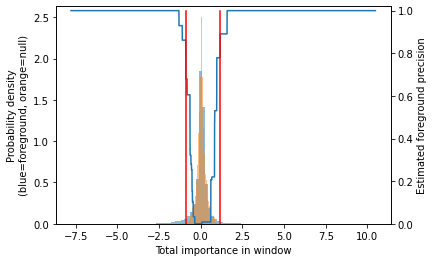

Got 480 coords
After resolving overlaps, got 480 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9319204081632653
MEMORY 5.176025088
480 identified in total
2 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [333, 147]
Idx to activities:  {0: '-1', 1: '1'}
MEMORY 5.176143872
On metacluster 1
Metacluster size 147
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 147
(Round 1) Computing coarse affmat
MEMORY 5.17625856
Beginning embedding computation
MEMORY 5.17625856
At the beginning of embedding call
MEMORY 5.17625856
before computing embeddings fwd
MEMORY 5.17625856


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:   53.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 5.181861888


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s


after computing embeddings rev
MEMORY 5.187260416
before computing sparse embeddings fwd
MEMORY 5.187260416
Constructing csr matrix...
csr matrix made in 0.03087472915649414 s
after computing sparse embeddings fwd
MEMORY 5.187395584
before computing sparse embeddings rev
MEMORY 5.187395584
Constructing csr matrix...
csr matrix made in 0.021904706954956055 s
after computing sparse embeddings rev
MEMORY 5.187575808
Finished embedding computation in 96.36 s
MEMORY 5.187575808
Starting affinity matrix computations
MEMORY 5.187575808
Batching in slices of size 147


[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:   43.0s finished
100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

Finished affinity matrix computations in 1.53 s
MEMORY 5.327028224
(Round 1) Computed coarse affmat
MEMORY 5.32676608
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 5.32676608
Launching nearest neighbors affmat calculation job
MEMORY 5.32676608


Parallel runs completed
MEMORY 5.326782464
Job completed in: 1.28 s
MEMORY 5.326782464
Launching nearest neighbors affmat calculation job
MEMORY 5.326782464
Parallel runs completed
MEMORY 5.326757888
Job completed in: 1.19 s
MEMORY 5.326757888
(Round 1) Computed affinity matrix on nearest neighbors in 2.59 s
MEMORY 5.326839808
Filtered down to 113 of 147
(Round 1) Retained 113 rows out of 147 after filtering
MEMORY 5.327151104
(Round 1) Computing density adapted affmat
MEMORY 5.327151104
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 5.326848
Beginning preprocessing + Leiden
Affmat shape: 113


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s


Quality: 0.07607749798933748
Got 5 clusters after round 1
Counts:
{3: 15, 0: 53, 1: 24, 2: 20, 4: 1}
MEMORY 5.32721664
(Round 1) Aggregating seqlets in each cluster
MEMORY 5.32721664
Aggregating for cluster 0 with 53 seqlets
MEMORY 5.32721664
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 51
Aggregating for cluster 1 with 24 seqlets
MEMORY 5.32721664


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.5s finished


Trimming eliminated 0 seqlets out of 24
Aggregating for cluster 2 with 20 seqlets
MEMORY 5.32721664
Skipped 1 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 19
Aggregating for cluster 3 with 15 seqlets
MEMORY 5.327220736
Skipped 1 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 14
Aggregating for cluster 4 with 1 seqlets
MEMORY 5.327220736
Trimming eliminated 0 seqlets out of 1
(Round 2) num seqlets: 97
(Round 2) Computing coarse affmat
MEMORY 5.327220736
Beginning embedding computation
MEMORY 5.327220736
At the beginning of embedding call
MEMORY 5.327220736
before computing embeddings fwd
MEMORY 5.327220736


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:   32.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 5.327220736


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.7s


after computing embeddings rev
MEMORY 5.327220736
before computing sparse embeddings fwd
MEMORY 5.327220736
Constructing csr matrix...
csr matrix made in 0.014510393142700195 s
after computing sparse embeddings fwd
MEMORY 5.327220736
before computing sparse embeddings rev
MEMORY 5.327220736
Constructing csr matrix...
csr matrix made in 0.015184640884399414 s
after computing sparse embeddings rev
MEMORY 5.327220736
Finished embedding computation in 65.41 s
MEMORY 5.327220736
Starting affinity matrix computations
MEMORY 5.327220736
Batching in slices of size 97


[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:   32.7s finished
100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Finished affinity matrix computations in 1.47 s
MEMORY 5.327220736
(Round 2) Computed coarse affmat
MEMORY 5.327220736
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 5.327220736
Launching nearest neighbors affmat calculation job
MEMORY 5.327220736


Parallel runs completed
MEMORY 5.327212544
Job completed in: 0.48 s
MEMORY 5.327212544
Launching nearest neighbors affmat calculation job
MEMORY 5.327212544
Parallel runs completed
MEMORY 5.327187968
Job completed in: 0.48 s
MEMORY 5.327187968
(Round 2) Computed affinity matrix on nearest neighbors in 1.05 s
MEMORY 5.327220736
Not applying filtering for rounds above first round
MEMORY 5.327220736
(Round 2) Computing density adapted affmat
MEMORY 5.327220736
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 5.327224832
Beginning preprocessing + Leiden
Affmat shape: 97


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s


Quality: 0.06552094293005266
Got 6 clusters after round 2
Counts:
{0: 47, 1: 22, 2: 22, 3: 3, 4: 2, 5: 1}
MEMORY 5.327224832
(Round 2) Aggregating seqlets in each cluster
MEMORY 5.327224832
Aggregating for cluster 0 with 47 seqlets
MEMORY 5.327224832
Trimming eliminated 0 seqlets out of 47
Aggregating for cluster 1 with 22 seqlets
MEMORY 5.327224832
Trimming eliminated 0 seqlets out of 22
Aggregating for cluster 2 with 22 seqlets
MEMORY 5.327224832


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.4s finished


Trimming eliminated 0 seqlets out of 22
Aggregating for cluster 3 with 3 seqlets
MEMORY 5.327224832
Trimming eliminated 0 seqlets out of 3
Aggregating for cluster 4 with 2 seqlets
MEMORY 5.327224832
Trimming eliminated 0 seqlets out of 2
Aggregating for cluster 5 with 1 seqlets
MEMORY 5.327224832
Trimming eliminated 0 seqlets out of 1
Got 6 clusters
Splitting into subclusters...
MEMORY 5.327224832
Inspecting pattern 0 for spurious merging
Inspecting pattern 1 for spurious merging
Inspecting pattern 2 for spurious merging
Inspecting pattern 3 for spurious merging
Inspecting pattern 4 for spurious merging
Inspecting pattern 5 for spurious merging
Merging on 6 clusters
MEMORY 5.327224832
On merging iteration 1
Numbers for each pattern pre-subsample: [47, 22, 22, 3, 2, 1]
Numbers after subsampling: [47, 22, 22, 3, 2, 1]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.3975486755371094 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.2441728115081787 s
Computing 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  47 out of  47 | elapsed:    0.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/

[t-SNE] Iteration 650: error = 0.6009877, gradient norm = 0.0000139 (50 iterations in 0.017s)
[t-SNE] Iteration 700: error = 0.6012578, gradient norm = 0.0000115 (50 iterations in 0.011s)
[t-SNE] Iteration 750: error = 0.6011660, gradient norm = 0.0000117 (50 iterations in 0.009s)
[t-SNE] Iteration 800: error = 0.6010613, gradient norm = 0.0000129 (50 iterations in 0.010s)
[t-SNE] Iteration 850: error = 0.6008365, gradient norm = 0.0000143 (50 iterations in 0.013s)
[t-SNE] Iteration 900: error = 0.6009588, gradient norm = 0.0000163 (50 iterations in 0.011s)
[t-SNE] Iteration 950: error = 0.6009347, gradient norm = 0.0000161 (50 iterations in 0.012s)
[t-SNE] Iteration 1000: error = 0.6008067, gradient norm = 0.0000182 (50 iterations in 0.009s)
[t-SNE] KL divergence after 1000 iterations: 0.600807
[t-SNE] Computed conditional probabilities for sample 47 / 47
[t-SNE] Mean sigma: 1125899906842624.000000
Beginning preprocessing + Leiden
Affmat shape: 47


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s


Quality: 5.684341886081034e-14
Got subclusters: Counter({0: 47})
On metacluster 0
Metacluster size 333
Relevant tasks:  ('task0',)
Relevant signs:  (-1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 333
(Round 1) Computing coarse affmat
MEMORY 5.327314944
Beginning embedding computation
MEMORY 5.327314944


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


At the beginning of embedding call
MEMORY 5.327314944
before computing embeddings fwd
MEMORY 5.327314944


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   55.3s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 5.330497536


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   54.7s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:  1.6min finished


after computing embeddings rev
MEMORY 5.341241344
before computing sparse embeddings fwd
MEMORY 5.341241344
Constructing csr matrix...
csr matrix made in 0.048323869705200195 s
after computing sparse embeddings fwd
MEMORY 5.3413888
before computing sparse embeddings rev
MEMORY 5.3413888
Constructing csr matrix...
csr matrix made in 0.054337263107299805 s
after computing sparse embeddings rev
MEMORY 5.3413888
Finished embedding computation in 193.46 s
MEMORY 5.340864512
Starting affinity matrix computations
MEMORY 5.340864512
Batching in slices of size 333


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Finished affinity matrix computations in 1.36 s
MEMORY 5.340864512
(Round 1) Computed coarse affmat
MEMORY 5.340864512
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 5.340864512
Launching nearest neighbors affmat calculation job
MEMORY 5.340864512


Parallel runs completed
MEMORY 5.340848128
Job completed in: 5.92 s
MEMORY 5.340848128
Launching nearest neighbors affmat calculation job
MEMORY 5.340848128
Parallel runs completed
MEMORY 5.340827648
Job completed in: 5.91 s
MEMORY 5.340827648
(Round 1) Computed affinity matrix on nearest neighbors in 11.97 s
MEMORY 5.340827648
Filtered down to 220 of 333
(Round 1) Retained 220 rows out of 333 after filtering
MEMORY 5.3408768
(Round 1) Computing density adapted affmat
MEMORY 5.3408768
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 5.340626944
Beginning preprocessing + Leiden
Affmat shape: 220


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s


Quality: 0.039468537162558735
Quality: 0.03948465402451929
Quality: 0.03951052353687566
Quality: 0.03957540668107311
Got 7 clusters after round 1
Counts:
{0: 76, 1: 66, 2: 65, 6: 1, 5: 2, 4: 2, 3: 8}
MEMORY 5.340626944
(Round 1) Aggregating seqlets in each cluster
MEMORY 5.340626944
Aggregating for cluster 0 with 76 seqlets
MEMORY 5.340626944


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.3s finished


Removed 1 duplicate seqlets
Skipped 1 seqlets that went over sequence edge during flank expansion
Skipped 2 due to duplicates
Trimming eliminated 0 seqlets out of 72
Aggregating for cluster 1 with 66 seqlets
MEMORY 5.340626944
Skipped 2 seqlets that went over sequence edge during flank expansion
Skipped 2 due to duplicates
Trimming eliminated 0 seqlets out of 62
Aggregating for cluster 2 with 65 seqlets
MEMORY 5.340626944
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 63
Aggregating for cluster 3 with 8 seqlets
MEMORY 5.340626944
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 7
Aggregating for cluster 4 with 2 seqlets
MEMORY 5.340626944
Trimming eliminated 0 seqlets out of 2
Aggregating for cluster 5 with 2 seqlets
MEMORY 5.340626944
Trimming eliminated 0 seqlets out of 2
Aggregating for cluster 6 with 1 seqlets
MEMORY 5.340626944
Trimming eliminated 0 seqlets out of 1
(Round 2

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 209 out of 209 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 5.340626944


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min


after computing embeddings rev
MEMORY 5.340626944
before computing sparse embeddings fwd
MEMORY 5.340626944
Constructing csr matrix...
csr matrix made in 0.029195070266723633 s
after computing sparse embeddings fwd
MEMORY 5.340626944
before computing sparse embeddings rev
MEMORY 5.340626944
Constructing csr matrix...
csr matrix made in 0.030041217803955078 s
after computing sparse embeddings rev
MEMORY 5.340626944
Finished embedding computation in 142.49 s
MEMORY 5.340626944
Starting affinity matrix computations
MEMORY 5.340626944
Batching in slices of size 209


[Parallel(n_jobs=4)]: Done 209 out of 209 | elapsed:  1.2min finished
100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Finished affinity matrix computations in 1.36 s
MEMORY 5.340626944
(Round 2) Computed coarse affmat
MEMORY 5.340626944
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 5.340626944
Launching nearest neighbors affmat calculation job
MEMORY 5.340626944


Parallel runs completed
MEMORY 5.340614656
Job completed in: 1.49 s
MEMORY 5.340614656
Launching nearest neighbors affmat calculation job
MEMORY 5.340614656
Parallel runs completed
MEMORY 5.34059008
Job completed in: 1.49 s
MEMORY 5.34059008
(Round 2) Computed affinity matrix on nearest neighbors in 3.13 s
MEMORY 5.34059008
Not applying filtering for rounds above first round
MEMORY 5.34059008
(Round 2) Computing density adapted affmat
MEMORY 5.34059008
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 5.34059008
Beginning preprocessing + Leiden
Affmat shape: 209


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.9s


Quality: 0.04572394034417836
Quality: 0.045726893008009216
Quality: 0.045729113108554646
Got 5 clusters after round 2
Counts:
{3: 33, 0: 73, 2: 43, 4: 5, 1: 55}
MEMORY 5.34059008
(Round 2) Aggregating seqlets in each cluster
MEMORY 5.34059008
Aggregating for cluster 0 with 73 seqlets
MEMORY 5.34059008


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.0s finished


Skipped 5 due to duplicates
Trimming eliminated 0 seqlets out of 68
Aggregating for cluster 1 with 55 seqlets
MEMORY 5.34059008
Skipped 4 due to duplicates
Trimming eliminated 0 seqlets out of 51
Aggregating for cluster 2 with 43 seqlets
MEMORY 5.34059008
Skipped 4 due to duplicates
Trimming eliminated 0 seqlets out of 39
Aggregating for cluster 3 with 33 seqlets
MEMORY 5.34059008
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 32
Dropping cluster 3 with 32 seqlets due to sign disagreement
Aggregating for cluster 4 with 5 seqlets
MEMORY 5.34059008
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 4
Got 4 clusters
Splitting into subclusters...
MEMORY 5.34059008
Inspecting pattern 0 for spurious merging
[t-SNE] Computed conditional probabilities for sample 68 / 68
[t-SNE] Mean sigma: 1.008817
Beginning preprocessing + Leiden
Affmat shape: 68


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 out of  68 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s


Quality: 0.08503216639454947
Quality: 0.08552484729284161
Quality: 0.08577873793174468
Got subclusters: Counter({0: 21, 1: 17, 3: 15, 2: 15})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.1s finished


Numbers for each pattern pre-subsample: [21, 17, 15, 15]
Numbers after subsampling: [21, 17, 15, 15]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.13805174827575684 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.11077046394348145 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.11646509170532227 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.12748456001281738 s
Cluster sizes
[21 17 15 15]
Cross-contamination matrix:
[[1.   0.52 0.43 0.55]
 [0.68 1.   0.46 0.53]
 [0.64 0.53 1.   0.64]
 [0.66 0.46 0.52 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.32 0.42 0.49]
 [0.32 1.   0.28 0.35]
 [0.42 0.28 1.   0.4 ]
 [0.49 0.35 0.4  1.  ]]
Inspecting pattern 1 for spurious merging
[t-SNE] Computed conditional probabilities for sample 51 / 51
[t-SNE] Mean sigma: 34.451547
Beginning preprocessing + Leiden
Affmat shape: 51


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s


Quality: 8.43769498715119e-15
Got subclusters: Counter({0: 51})
On merging iteration 1
Numbers for each pattern pre-subsample: [51]
Numbers after subsampling: [51]
Computing sims for pattern 0
Computed sims for pattern 0 in 3.266334533691406e-05 s
Cluster sizes
[51]
Cross-contamination matrix:
[[1.]]
Pattern-to-pattern sim matrix:
[[1.]]
Inspecting pattern 2 for spurious merging
Inspecting pattern 3 for spurious merging
Merging on 7 clusters
MEMORY 5.34059008
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.0s finished


Numbers for each pattern pre-subsample: [21, 17, 15, 15, 51, 39, 4]
Numbers after subsampling: [21, 17, 15, 15, 51, 39, 4]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.30164337158203125 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.22868824005126953 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.23799371719360352 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.24180078506469727 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.5468153953552246 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.4931151866912842 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.08882379531860352 s
Cluster sizes
[21 17 15 15 51 39  4]
Cross-contamination matrix:
[[1.   0.52 0.43 0.55 0.25 0.25 0.46]
 [0.68 1.   0.46 0.53 0.37 0.3  0.44]
 [0.64 0.53 1.   0.64 0.49 0.36 0.51]
 [0.66 0.46 0.52 1.   0.22 0.29 0.2 ]
 [0.69 0.67 0.74 0.58 1.   0.55 0.54]
 [0.43 0.34 0.37 0.44 0.35 1.   0.55]
 [0.58 0.49 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    0.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/

[t-SNE] Iteration 650: error = 0.7822303, gradient norm = 0.0005536 (50 iterations in 0.018s)
[t-SNE] Iteration 700: error = 0.6817135, gradient norm = 0.0003422 (50 iterations in 0.018s)
[t-SNE] Iteration 750: error = 0.6288907, gradient norm = 0.0001322 (50 iterations in 0.011s)
[t-SNE] Iteration 800: error = 0.6228719, gradient norm = 0.0000632 (50 iterations in 0.010s)
[t-SNE] Iteration 850: error = 0.6209500, gradient norm = 0.0000452 (50 iterations in 0.010s)
[t-SNE] Iteration 900: error = 0.6191314, gradient norm = 0.0000393 (50 iterations in 0.013s)
[t-SNE] Iteration 900: did not make any progress during the last 300 episodes. Finished.
[t-SNE] KL divergence after 900 iterations: 0.619131
[t-SNE] Computed conditional probabilities for sample 51 / 51
[t-SNE] Mean sigma: 34.451547
Beginning preprocessing + Leiden
Affmat shape: 51


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s


Quality: 8.43769498715119e-15
Got subclusters: Counter({0: 51})


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.1s finished


In [13]:
import numpy as np
%matplotlib inline
import modisco

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=21,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        final_min_cluster_size=40)
                )(
                 task_names=["task0"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

In [14]:
import h5py
import modisco.util
from importlib import reload
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

Metaclusters heatmap


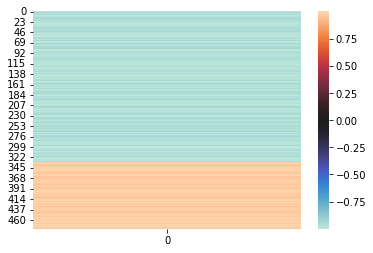

metacluster_0
activity pattern: [-1]
metacluster_0 pattern_0
total seqlets: 51
onehot, fwd and rev:


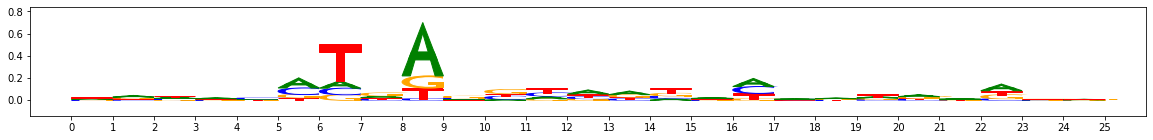

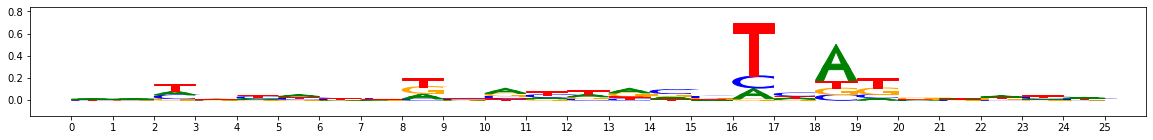

metacluster_1
activity pattern: [1]
metacluster_1 pattern_0
total seqlets: 47
onehot, fwd and rev:


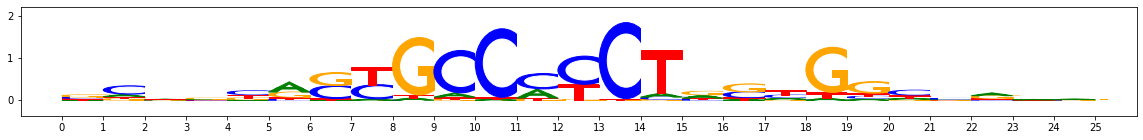

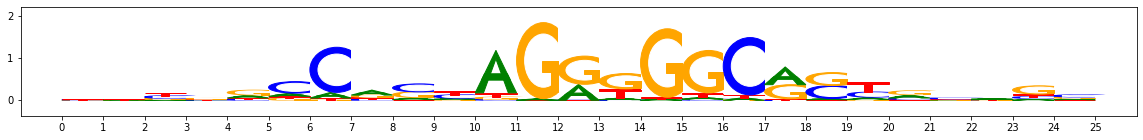

In [15]:
from collections import Counter
import numpy as np

from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
hdf5_results.close()